In [1]:
import math
import itertools

import numpy as np
import pandas as pd
import scipy

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

import sklearn
from sklearn import ensemble
from sklearn import pipeline
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics.pairwise import cosine_similarity
import patsy

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
#import statannot
import statannotations
from statannotations.Annotator import Annotator
from statannotations.stats.StatTest import StatTest
#import plotnine as p9

import Bio.motifs as motifs

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import gensim

from gensim.test.utils import common_texts

from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [5]:
# paths 
data_dir = "../data/"

In [7]:
halflife_df = pd.read_csv(data_dir + "Scer_half_life.csv")
halflife_pombe_df = pd.read_csv(data_dir + "Pombe_half_life.csv")
puf3_binding = pd.read_csv(data_dir + "puf3_clip_targets.tsv", sep="\t")

In [7]:
#[x for x in halflife_pombe_df.columns]

In [8]:
emb = np.load(data_dir + 'results/embeddings/scer_seq_embeddings.npy')
emb_pombe = np.load(data_dir + "results/embeddings/embeddings_s_pombe.npy") 

# Utility Functions

In [9]:
class Kmerizer:
    
    def __init__(self, k, log=False, divide=False, leave_one_out=False):
        self.k = k
        if leave_one_out:
            self.kmers = {"".join(x):i for i,x in zip(range(4**k), [x for x in itertools.product("ACGT",repeat=k)][:-1])}
        else:
            self.kmers = {"".join(x):i for i,x in zip(range(4**k), itertools.product("ACGT",repeat=k))}
        self.log = log
        self.divide = divide
        
    def kmerize(self, seq):
        counts = np.zeros(4**self.k)
        i = 0
        while i < len(seq) - self.k + 1: 
            kmer = seq[i:i+self.k]
            counts[self.kmers[kmer]] += 1
            i += 1
        if self.divide:
            counts = counts/len(seq)
        if self.log:
            counts = np.log(counts + 1)
        return counts
    
    def tokenize(self, seq, jump=False):
        kmers = []
        i = 0
        while i < len(seq) - self.k + 1: 
            kmer = seq[i:i+self.k]
            kmers.append(kmer)
            if jump:
                i += self.k
            else:
                i += 1
        return kmers
    
kmerizer2 = Kmerizer(k=2)
kmerizer3 = Kmerizer(k=3)
kmerizer4 = Kmerizer(k=4)
kmerizer5 = Kmerizer(k=5)
kmerizer6 = Kmerizer(k=6)
kmerizer7 = Kmerizer(k=7)

In [10]:
def pearson_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    if len(y_pred.shape) == 2:
        y_pred = y_pred.reshape(-1)
    return scipy.stats.pearsonr(y, y_pred)[0]

def pearson_r2(estimator, X, y):
    y_pred = estimator.predict(X)
    #print(estimator[1].alpha_)
    if len(y_pred.shape) == 2:
        y_pred = y_pred.reshape(-1)
    return scipy.stats.pearsonr(y, y_pred)[0] ** 2

def pearson_r2_metric(y_true, y_pred):
    return scipy.stats.pearsonr(y_true, y_pred)[0] ** 2

def bootstrap_normal(x, y):
    x, y = np.array(x), np.array(y)
    z_val = np.abs(((x - y).mean())/((x - y).std()))
    return z_val, (1 - scipy.stats.norm.cdf(z_val) + scipy.stats.norm.cdf(-z_val))

custom_long_name = 'Bootstrap Normal'
custom_short_name = 'Normal'
custom_func = bootstrap_normal
bstrap_normal_test = StatTest(custom_func, custom_long_name, custom_short_name)

def bootstrap_empirical(x, y):
    x, y = np.array(x), np.array(y)
    diffs = (x - y)
    stat = np.sum(diffs < 0) 
    p = (stat + 1)/(len(x) + 1)
    #if np.median(diffs) > 0:
    #    stat = np.sum(diffs < 0) 
    #    p = 2*(stat + 1)/(len(x) + 1)
    #else:
    #    stat = np.sum(diffs > 0) 
    #    p = 2*(stat + 1)/(len(x) + 1)
    return stat, p

custom_long_name = 'Bootstrap Empirical'
custom_short_name = 'Empirical'
custom_func = bootstrap_empirical
bstrap_empirical_test = StatTest(custom_func, custom_long_name, custom_short_name)

# S. cerevisiae Half Life

## Prepare data

In [11]:
codon_vars = ['TTC','TTA', 'TTG', 'TCT', 'TCC', 'TCA', 'TCG', 'TAT', 'TAC', 'TGT', 'TGC',
       'TGG', 'CTT', 'CTC', 'CTA', 'CTG', 'CCT', 'CCC', 'CCA', 'CCG', 'CAT',
       'CAC', 'CAA', 'CAG', 'CGT', 'CGC', 'CGA', 'CGG', 'ATT', 'ATC', 'ATA',
       'ATG', 'ACT', 'ACC', 'ACA', 'ACG', 'AAT', 'AAC', 'AAA', 'AAG', 'AGT',
       'AGC', 'AGA', 'AGG', 'GTT', 'GTC', 'GTA', 'GTG', 'GCT', 'GCC', 'GCA',
       'GCG', 'GAT', 'GAC', 'GAA', 'GAG', 'GGT', 'GGC', 'GGA', 'GGG', 'TTT']

signif_vars = ["UTR5_length_log","GC_content_UTR5","CDS_deltaG","num_uAUG","UTR3_length_log","TGTAAATA","TGCAT","ATATTC","TTTTTTA"]

In [12]:
# recompute GC content
halflife_df['GC_content_UTR5'] = (halflife_df['UTR5_seq'].str.count('G') + halflife_df['UTR5_seq'].str.count('C'))/halflife_df['UTR5_seq'].str.len()
halflife_df['GC_content_UTR3'] = (halflife_df['UTR3_seq'].str.count('G') + halflife_df['UTR3_seq'].str.count('C'))/halflife_df['UTR3_seq'].str.len()
halflife_df['GC_content_CDS'] = (halflife_df['CDS_seq'].str.count('G') + halflife_df['CDS_seq'].str.count('C'))/halflife_df['CDS_seq'].str.len()
# make uAUG an indicator
halflife_df['num_uAUG'] = halflife_df['num_uAUG'] > 0
# make codons into ratios
for codon in codon_vars[:-1]:
    halflife_df[codon] = halflife_df[codon]/halflife_df['CDS_length']
    #halflife_df[codon] = np.log2(halflife_df[codon]/halflife_df['CDS_length'] + 1)
# finally log the length
halflife_df['UTR5_length_log'] = np.log2(halflife_df['UTR5_length'])
halflife_df['UTR3_length_log'] = np.log2(halflife_df['UTR3_length'])
halflife_df['CDS_length_log'] = np.log2(halflife_df['CDS_length'])

In [13]:
halflife_df["log_hl"] = np.log2(halflife_df["hlt.wt"])

In [15]:
# Optimal: 4 20 64 True
#rows = []
#for k in [3,4,5,6]:
#    for window in [5,10,20]:
#        for vector_size in [32, 64, 128]:
#            for overlap in [True, False]:
#                print(k,window,vector_size,overlap)
#                kmerizer_w2v = Kmerizer(k=4)
#                w2v_model = Word2Vec(sentences=halflife_df['UTR3_seq'].apply(lambda x: kmerizer_w2v.tokenize(x, jump=False)), 
#                                     vector_size=128, window=5, min_count=1, workers=4, sg=1)
#                word2vec_emb = halflife_df['UTR3_seq'].apply(lambda x: np.mean([w2v_model.wv[x]  for x in kmerizer_w2v.tokenize(x, jump=False)],axis=0))
#                word2vec_emb = [x if len(x.shape) > 0 else np.zeros(128) for x in word2vec_emb]
#                X_w2v = np.stack(word2vec_emb,axis=0)#np.stack(doc2vec_emb,axis=0)
#                y = y_obs
#                pipe = pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.linear_model.Ridge(alpha=10))
#                r2 = cross_val_score(pipe,X_w2v,y,scoring=pearson_r2,cv=3, n_jobs=-1).mean()
#                print(r2)
#                rows.append({"k":k, "window":window, "vector_size":vector_size, "overlap":overlap , "r2":r2})

In [14]:
y_obs = np.array(halflife_df["log_hl"])

X_base = np.array(halflife_df[codon_vars[:-1] + signif_vars[:-4]])

X_jun = np.array(halflife_df[codon_vars[:-1] + signif_vars])
X_emb = np.concatenate([X_base, emb],axis=1)
X_gc = np.array(halflife_df[codon_vars[:-1] + signif_vars[:-4] + ['GC_content_UTR3']])

X_2mer = np.concatenate([X_base, np.stack(halflife_df['UTR3_seq'].apply(lambda x: kmerizer2.kmerize(x)))],axis=1)
X_3mer = np.concatenate([X_base, np.stack(halflife_df['UTR3_seq'].apply(lambda x: kmerizer3.kmerize(x)))],axis=1)
X_4mer = np.concatenate([X_base, np.stack(halflife_df['UTR3_seq'].apply(lambda x: kmerizer4.kmerize(x)))],axis=1)
X_5mer = np.concatenate([X_base, np.stack(halflife_df['UTR3_seq'].apply(lambda x: kmerizer5.kmerize(x)))],axis=1)
X_6mer = np.concatenate([X_base, np.stack(halflife_df['UTR3_seq'].apply(lambda x: kmerizer6.kmerize(x)))],axis=1)

kmerizer_w2v = Kmerizer(k=4)
w2v_model = Word2Vec(sentences=halflife_df['UTR3_seq'].apply(lambda x: kmerizer_w2v.tokenize(x, jump=True)), 
                     vector_size=64, window=20, min_count=1, workers=4, sg=1)
word2vec_emb = halflife_df['UTR3_seq'].apply(lambda x: np.mean([w2v_model.wv[x]  for x in kmerizer_w2v.tokenize(x, jump=False)],axis=0))
word2vec_emb = [x if len(x.shape) > 0 else np.zeros(64) for x in word2vec_emb]
X_w2v = np.stack(word2vec_emb,axis=0)#np.stack(doc2vec_emb,axis=0)

/opt/modules/i12g/anaconda/envs/motifs/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


## Predict Half Life

In [15]:
data_matrices = {"Embedding":X_emb, 
                 "GC Content":X_gc,
                 "2-mer counts":X_2mer, 
                 "3-mer counts":X_3mer, 
                 "4-mer counts":X_4mer,
                 "5-mer counts":X_5mer, 
                 "6-mer counts":X_6mer,
                 "Word2Vec": X_w2v,
                 "Cheng Features":X_jun}

rows = []
df_list = []
total_len = X_base.shape[0]
n_splits = 10

np.random.seed(42)

for key in data_matrices:
    y = y_obs
    X = data_matrices[key]
    pipe = pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.linear_model.RidgeCV(cv=10))
    #rmse = -cross_val_score(pipe,X,y,scoring="neg_root_mean_squared_error",cv=10).mean()
    r2 = cross_val_score(pipe,X,y,scoring=pearson_r2,cv=n_splits, n_jobs=-1)
    for r2_val in r2:
        rows.append({"model":key, "r2":r2_val})
    #rows.append({"model":key, "rmse":rmse, "r2":r2})

#for smpl in range(100):
#    if smpl % 10 == 0:
#        print(smpl)
#    train = np.random.choice(list(range(total_len)),total_len)
#    test = list(set(range(total_len)) - set(train))
#    for key in data_matrices:
#        y_train = y_obs[train]
#        X_train = data_matrices[key][train]
#        y_test = y_obs[test]
#        X_test = data_matrices[key][test]
#        pipe = pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.linear_model.Ridge(alpha=10))
#        pipe.fit(X_train, y_train)
#        y_pred = pipe.predict(X_test)
#        rmse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared=False)
#        r2 = pearson_r2_metric(y_test, y_pred)
#        rows.append({"model":key, "rmse":rmse, "r2":r2})
        
metrics_scer = pd.DataFrame(rows)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

In [16]:
metrics_scer.groupby('model').mean()

,r2
model,
2-mer counts,0.581943
3-mer counts,0.583559
4-mer counts,0.567678
5-mer counts,0.483933
6-mer counts,0.154707
Cheng Features,0.588730
Embedding,0.593907
GC Content,0.576784
Word2Vec,0.073923


In [17]:
metrics_scer.groupby('model').sem()

,r2
model,
2-mer counts,0.014285
3-mer counts,0.015341
4-mer counts,0.016964
5-mer counts,0.015773
6-mer counts,0.012223
Cheng Features,0.013871
Embedding,0.014660
GC Content,0.012971
Word2Vec,0.009495


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Embedding vs. GC Content: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.953e-03 Stat=0.000e+00
Embedding vs. 2-mer counts: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:9.766e-03 Stat=3.000e+00
Embedding vs. 3-mer counts: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.711e-02 Stat=7.000e+00
Embedding vs. 4-mer counts: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.906e-03 Stat=1.000e+00
Embedding vs. 5-mer counts: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.953e-03 Stat=0.000e+00
Embedding vs. 6-mer counts: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.953e-03 Stat=0.000e+00
Embedding vs. Word2Vec: Wilcoxon test (paired samples) with Benja

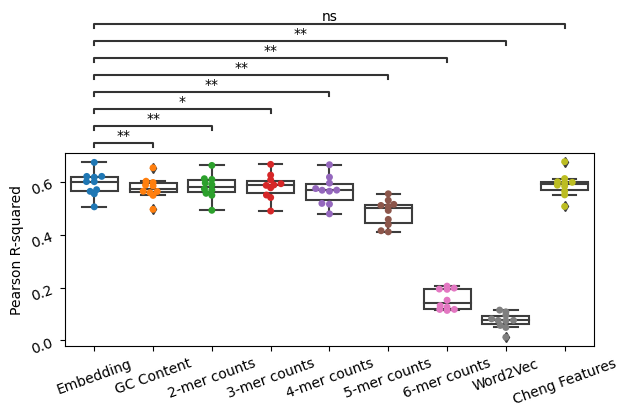

In [18]:
dims = (6.4, 6)

statplot_df = metrics_scer.query('model not in ["GC + 2,3-mers", "GC + 2,3,4-mers"]')
x = "model"
y = "r2"
y_lab = "Pearson R-squared"

box_pairs=[
    ("Embedding", "GC Content"),
    ("Embedding", "2-mer counts"),
    ("Embedding", "3-mer counts"),
    ("Embedding", "4-mer counts"),
    ("Embedding", "5-mer counts"),
    ("Embedding", "6-mer counts"),
    ("Embedding", "Word2Vec"),
    ("Embedding", "Cheng Features"),
    ]
fig, ax = plt.subplots(figsize=dims, dpi=100)
ax = sns.boxplot(data=statplot_df, x=x, y=y, boxprops={'facecolor':'None'})
ax = sns.swarmplot(data=statplot_df, x=x, y=y)

annotator = Annotator(ax, box_pairs, data=statplot_df, x=x, y=y)
annotator.configure(test="Wilcoxon", text_format='star', loc='outside', comparisons_correction="BH")
annotator.apply_and_annotate()

ax.set_xlabel("",fontsize=10, color="black")
ax.set_ylabel(y_lab,fontsize=10, color="black")

ax.tick_params(labelsize=10, rotation=20)
plt.tight_layout()



# S. pombe Half Life

## Prepare data

In [19]:
codon_vars_pombe = ['TTC','TTA', 'TTG', 'TCT', 'TCC', 'TCA', 'TCG', 'TAT', 'TAC', 'TGT', 'TGC',
       'TGG', 'CTT', 'CTC', 'CTA', 'CTG', 'CCT', 'CCC', 'CCA', 'CCG', 'CAT',
       'CAC', 'CAA', 'CAG', 'CGT', 'CGC', 'CGA', 'CGG', 'ATT', 'ATC', 'ATA',
       'ATG', 'ACT', 'ACC', 'ACA', 'ACG', 'AAT', 'AAC', 'AAA', 'AAG', 'AGT',
       'AGC', 'AGA', 'AGG', 'GTT', 'GTC', 'GTA', 'GTG', 'GCT', 'GCC', 'GCA',
       'GCG', 'GAT', 'GAC', 'GAA', 'GAG', 'GGT', 'GGC', 'GGA', 'GGG', 'TTT']

signif_vars_pombe = ['UTR3_length_log','UTR5_length_log','CDS_length_log',
               "stopPlus1",
               "num_uAUG","CAACCA","ACCAAC",
               "GC_content_UTR5","UTR5_deltaG","CDS_deltaG","GC_content_CDS",
               "UTR3_deltaG","GC_content_UTR3","TATTTAT","TTAATGA","ACTAAT"]


In [20]:
# recompute GC content
halflife_pombe_df['GC_content_UTR5'] = (halflife_pombe_df['UTR5_seq'].str.count('G') + halflife_pombe_df['UTR5_seq'].str.count('C'))/halflife_pombe_df['UTR5_seq'].str.len()
halflife_pombe_df['GC_content_UTR3'] = (halflife_pombe_df['UTR3_seq'].str.count('G') + halflife_pombe_df['UTR3_seq'].str.count('C'))/halflife_pombe_df['UTR3_seq'].str.len()
#halflife_pombe_df['GC_content_CDS'] = (halflife_pombe_df['CDS_seq'].str.count('G') + halflife_pombe_df['CDS_seq'].str.count('C'))/halflife_pombe_df['CDS_seq'].str.len()
# make uAUG an indicator
halflife_pombe_df['num_uAUG'] = halflife_pombe_df['num_uAUG'] > 0
# make codons into ratios
for codon in codon_vars_pombe[:-1]:
    halflife_pombe_df[codon] = halflife_pombe_df[codon]/halflife_pombe_df['CDS_length']
    #halflife_df[codon] = np.log2(halflife_df[codon]/halflife_df['CDS_length'] + 1)
# finally log the length
halflife_pombe_df['UTR5_length_log'] = np.log2(halflife_pombe_df['UTR5.length'])
halflife_pombe_df['UTR3_length_log'] = np.log2(halflife_pombe_df['UTR3.length'])
halflife_pombe_df['CDS_length_log'] = np.log2(halflife_pombe_df['CDS_length'])

In [21]:
halflife_pombe_df["log_hl"] = np.log2(halflife_pombe_df["half.life"])

In [22]:
ols_hl_pombe_full = (statsmodels.regression.linear_model.OLS
                  .from_formula('log_hl ~ {}'.format("+".join(codon_vars_pombe + signif_vars_pombe)),
                                data=halflife_pombe_df))#.query('UTR5_length >= 20 and UTR3_length >= 20')))

res_hl_pombe_full = ols_hl_pombe_full.fit()
#res_hl_pombe_full.summary()

In [23]:
y_obs = np.array(halflife_pombe_df["log_hl"])

X_base = np.asarray(patsy.dmatrix('~ -1 + {}'.format("+".join(codon_vars_pombe[:-1] + signif_vars_pombe[:-5])), 
              data=halflife_pombe_df))

X_jun = np.concatenate([X_base, np.array(halflife_pombe_df[signif_vars_pombe[-5:]])],axis=1)
X_emb = np.concatenate([X_base, emb_pombe],axis=1)
X_gc = np.concatenate([X_base, np.array(halflife_pombe_df[['GC_content_UTR3']])],axis=1)

X_2mer = np.concatenate([X_base, np.stack(halflife_pombe_df['UTR3_seq'].apply(lambda x: kmerizer2.kmerize(x)))],axis=1)
X_3mer = np.concatenate([X_base, np.stack(halflife_pombe_df['UTR3_seq'].apply(lambda x: kmerizer3.kmerize(x)))],axis=1)
X_4mer = np.concatenate([X_base, np.stack(halflife_pombe_df['UTR3_seq'].apply(lambda x: kmerizer4.kmerize(x)))],axis=1)
X_5mer = np.concatenate([X_base, np.stack(halflife_pombe_df['UTR3_seq'].apply(lambda x: kmerizer5.kmerize(x)))],axis=1)
X_6mer = np.concatenate([X_base, np.stack(halflife_pombe_df['UTR3_seq'].apply(lambda x: kmerizer6.kmerize(x)))],axis=1)

kmerizer_w2v = Kmerizer(k=4)
w2v_model = Word2Vec(sentences=halflife_pombe_df['UTR3_seq'].apply(lambda x: kmerizer_w2v.tokenize(x, jump=True)), 
                     vector_size=64, window=20, min_count=1, workers=4, sg=1)
word2vec_emb = halflife_pombe_df['UTR3_seq'].apply(lambda x: np.mean([w2v_model.wv[x]  for x in kmerizer_w2v.tokenize(x, jump=False)],axis=0))
word2vec_emb = [x if len(x.shape) > 0 else np.zeros(128) for x in word2vec_emb]
X_w2v = np.stack(word2vec_emb,axis=0)#np.stack(doc2vec_emb,axis=0)

## Predict Half Life

In [24]:
data_matrices = {"Embedding":X_emb, 
                 "GC Content":X_gc,
                 "2-mer counts":X_2mer, 
                 "3-mer counts":X_3mer, 
                 "4-mer counts":X_4mer,
                 "5-mer counts":X_5mer, 
                 "6-mer counts":X_6mer,
                 "Word2Vec": X_w2v,
                 "Eser Features":X_jun}

rows = []
df_list = []
total_len = X_base.shape[0]
n_splits = 10

np.random.seed(42)

for key in data_matrices:
    y = y_obs
    X = data_matrices[key]
    pipe = pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.linear_model.RidgeCV(cv=10))
    #rmse = -cross_val_score(pipe,X,y,scoring="neg_root_mean_squared_error",cv=10).mean()
    r2 = cross_val_score(pipe,X,y,scoring=pearson_r2,cv=n_splits, n_jobs=-1)
    for r2_val in r2:
        rows.append({"model":key, "r2":r2_val})
    #rows.append({"model":key, "rmse":rmse, "r2":r2})
        
metrics_pombe = pd.DataFrame(rows)

In [25]:
metrics_pombe.groupby('model').mean()

,r2
model,
2-mer counts,0.422287
3-mer counts,0.425365
4-mer counts,0.423442
5-mer counts,0.327978
6-mer counts,0.048756
Embedding,0.453409
Eser Features,0.411122
GC Content,0.388169
Word2Vec,0.068085


In [26]:
metrics_pombe.groupby('model').sem()

,r2
model,
2-mer counts,0.015482
3-mer counts,0.015083
4-mer counts,0.014223
5-mer counts,0.016147
6-mer counts,0.006686
Embedding,0.018330
Eser Features,0.015422
GC Content,0.014173
Word2Vec,0.011120


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Embedding vs. GC Content: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Embedding vs. 2-mer counts: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=1.000e+00
Embedding vs. 3-mer counts: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=1.000e+00
Embedding vs. 4-mer counts: Wilcoxon test (paired samples), P_val:4.883e-02 Stat=8.000e+00
Embedding vs. 5-mer counts: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Embedding vs. 6-mer counts: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Embedding vs. Word2Vec: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Embedding vs. Eser Features: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=1.000e+00


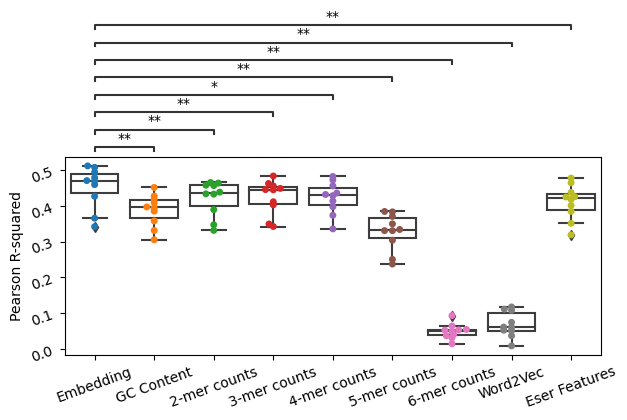

In [27]:
dims = (6.4,6)
#statplot_df = errors_scer.query('model not in ["GC + 2,3-mers", "GC + 2,3,4-mers"]')
statplot_df = metrics_pombe.query('model not in ["GC + 2,3-mers", "GC + 2,3,4-mers"]')
x = "model"
y = "r2"
y_lab = "Pearson R-squared"
#hue = "Motif_count"
box_pairs=[
    ("Embedding", "GC Content"),
    ("Embedding", "2-mer counts"),
    ("Embedding", "3-mer counts"),
    ("Embedding", "4-mer counts"),
    ("Embedding", "5-mer counts"),
    ("Embedding", "6-mer counts"),
    ("Embedding", "Word2Vec"),
    ("Embedding", "Eser Features"),
    ]
fig, ax = plt.subplots(figsize=dims, dpi=100)
ax = sns.swarmplot(data=statplot_df, x=x, y=y)
ax = sns.boxplot(data=statplot_df, x=x, y=y, boxprops={'facecolor':'None'})
#sns.swarmplot(data = metrics_pombe.head(6), x=x, y=y)
#plt.yscale('log')
#plt.legend(bbox_to_anchor=(1, 0.5), title="Motif_count")
#statannot.add_stat_annotation(ax, data=statplot_df, x=x, y=y, #hue=hue, 
#                              box_pairs=box_pairs, comparisons_correction="bh",
#                    test='Wilcoxon', loc='inside',  verbose=2)

annotator = Annotator(ax, box_pairs, data=statplot_df, x=x, y=y)
annotator.configure(test="Wilcoxon", text_format='star', loc='outside', comparisons_correction=None)
annotator.apply_and_annotate()

ax.set_xlabel("",fontsize=10, color="black")
ax.set_ylabel(y_lab,fontsize=10, color="black")


ax.tick_params(labelsize=10, rotation=20)
plt.tight_layout()


# MPRA

In [46]:
mpra_df = pd.read_csv(data_dir + "segal_2015.tsv",sep="\t").dropna().reset_index(drop=True).reset_index()

In [36]:
emb_mpra = np.load(data_dir + "results/embeddings/mpra_embeddings.npy")

In [37]:
#mpra_df.rename(columns={'Oligo Sequence':"sequence"}).to_csv(data_dir + "segal_2015.tsv",index=None)

In [48]:
mpra_df['TGTAAATA'] = mpra_df['Oligo Sequence'].str.count('TGTAAATA')
mpra_df['TGCAT'] = mpra_df['Oligo Sequence'].str.count('TGCAT')
mpra_df['ATATTC'] = mpra_df['Oligo Sequence'].str.count('ATATTC')
mpra_df['TTTTTTA'] = mpra_df['Oligo Sequence'].str.count('TTTTTTA')
mpra_df['GC_content_UTR3'] = (mpra_df['Oligo Sequence'].str.count('G') + mpra_df['Oligo Sequence'].str.count('C'))/mpra_df['Oligo Sequence'].str.len()
#mpra_df['UTR3_length_log'] = np.log2(mpra_df['Oligo Sequence'].str.len()) # always the same

In [49]:
kmerizer5 = Kmerizer(k=5)
X_5mer = np.stack(mpra_df['Oligo Sequence'].apply(lambda x: kmerizer5.kmerize(x)))

X_sim = cosine_similarity(X_5mer, X_5mer)

cutoff = 0.7
unassigned = set(range(X_sim.shape[0]))
blocks = []
idx = 0
while True:
    #print(np.where(X_sim[idx] > 0.7))
    similar = set(np.where(X_sim[idx] > cutoff)[0])
    blocks.append(similar)
    unassigned = unassigned - similar
    if len(unassigned) == 0:
        break
    else:
        idx = unassigned.pop()
len(blocks)

def get_block(elem, blocks):
    for idx, block in enumerate(blocks):
        if elem in block:
            return idx
    assert False

mpra_df['block'] = mpra_df['index'].apply(lambda x: get_block(x, blocks))

In [50]:
y_obs = np.array(mpra_df["Expression"])
groups = np.array(mpra_df['block'])

X_gc = np.array(mpra_df[['GC_content_UTR3']])
X_2mer = np.stack(mpra_df['Oligo Sequence'].apply(lambda x: kmerizer2.kmerize(x)))
X_3mer = np.stack(mpra_df['Oligo Sequence'].apply(lambda x: kmerizer3.kmerize(x)))
X_4mer = np.stack(mpra_df['Oligo Sequence'].apply(lambda x: kmerizer4.kmerize(x)))
X_5mer = np.stack(mpra_df['Oligo Sequence'].apply(lambda x: kmerizer5.kmerize(x)))
X_6mer = np.stack(mpra_df['Oligo Sequence'].apply(lambda x: kmerizer6.kmerize(x)))
#X_7mer = np.stack(mpra_df['Oligo Sequence'].apply(lambda x: kmerizer7.kmerize(x)))
X_jun = np.array(mpra_df[['TGTAAATA','TGCAT','ATATTC','TTTTTTA']])
X_emb = emb_mpra

kmerizer_w2v = Kmerizer(k=4)
w2v_model = Word2Vec(sentences=mpra_df['Oligo Sequence'].apply(lambda x: kmerizer_w2v.tokenize(x, jump=False)), 
                     vector_size=128, window=5, min_count=1, workers=4, sg=1)
word2vec_emb = mpra_df['Oligo Sequence'].apply(lambda x: np.mean([w2v_model.wv[x]  for x in kmerizer_w2v.tokenize(x, jump=False)],axis=0))
X_w2v = np.stack(word2vec_emb,axis=0)#np.stack(doc2vec_emb,axis=0)

In [51]:
%%capture
data_matrices = {"Embedding":X_emb,
                 "GC Content":X_gc,
                 "2-mer counts":X_2mer, 
                 "3-mer counts":X_3mer, 
                 "4-mer counts":X_4mer,
                 "5-mer counts":X_5mer,
                 "6-mer counts":X_6mer,
                 "Word2Vec": X_w2v,
                }

rows = []
df_list = []
total_len = X_emb.shape[0]
np.random.seed(42)

for key in data_matrices:
    y = y_obs
    X = data_matrices[key]
    pipe = pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.linear_model.RidgeCV(cv=3)) #limit runtime
    #rmse = -cross_val_score(pipe,X,y,scoring="neg_root_mean_squared_error",cv=sklearn.model_selection.GroupKFold(n_splits=10), groups=groups)#.mean()
    r2 = cross_val_score(pipe,X,y,scoring=pearson_r2,cv=sklearn.model_selection.GroupKFold(n_splits=10), groups=groups, n_jobs=-1)#.mean()
    for r2_val in r2:
        rows.append({"model":key, "r2":r2_val})

metrics_mpra = pd.DataFrame(rows)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

/opt/modules/i12g/anaconda/envs/motifs/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.48551e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/modules/i12g/anaconda/envs/motifs/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.34078e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/modules/i12g/anaconda/envs/motifs/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.18594e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/modules/i12g/anaconda/envs/motifs/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.37564e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrit

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

In [52]:
metrics_mpra.groupby('model').mean()

,r2
model,
2-mer counts,0.266482
3-mer counts,0.277097
4-mer counts,0.296279
5-mer counts,0.331042
6-mer counts,0.296170
Embedding,0.406248
GC Content,0.159257
Word2Vec,0.286446


In [53]:
metrics_mpra.groupby('model').sem()

,r2
model,
2-mer counts,0.030454
3-mer counts,0.032543
4-mer counts,0.024480
5-mer counts,0.026330
6-mer counts,0.031655
Embedding,0.026667
GC Content,0.020248
Word2Vec,0.028256


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Embedding vs. GC Content: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.953e-03 Stat=0.000e+00
Embedding vs. 2-mer counts: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.953e-03 Stat=0.000e+00
Embedding vs. 3-mer counts: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.953e-03 Stat=0.000e+00
Embedding vs. 4-mer counts: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:9.766e-03 Stat=3.000e+00
Embedding vs. 5-mer counts: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.711e-02 Stat=7.000e+00
Embedding vs. 6-mer counts: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:9.766e-03 Stat=3.000e+00
Embedding vs. Word2Vec: Wilcoxon test (paired samples) with Benja

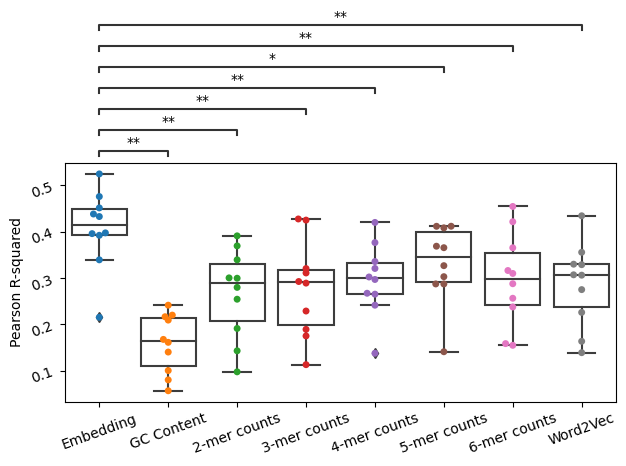

In [54]:
dims = (6.4, 6)
#statplot_df = errors_scer.query('model not in ["GC + 2,3-mers", "GC + 2,3,4-mers"]')
statplot_df = metrics_mpra
x = "model"
y = "r2"
y_lab = "Pearson R-squared"
#hue = "Motif_count"
box_pairs=[
    ("Embedding", "GC Content"),
    ("Embedding", "2-mer counts"),
    ("Embedding", "3-mer counts"),
    ("Embedding", "4-mer counts"),
    ("Embedding", "5-mer counts"),
    ("Embedding", "6-mer counts"),
    ("Embedding", "Word2Vec"),
    #("Embeddings", "Cheng Motifs")
    ]
fig, ax = plt.subplots(figsize=dims, dpi=100)
ax = sns.swarmplot(data=statplot_df, x=x, y=y)
ax = sns.boxplot(data=statplot_df, x=x, y=y, boxprops={'facecolor':'None'})
#sns.swarmplot(data = metrics_mpra.tail(6), x=x, y=y)
#plt.yscale('log')
#plt.legend(bbox_to_anchor=(1, 0.5), title="Motif_count")
#statannot.add_stat_annotation(ax, data=statplot_df, x=x, y=y, #hue=hue, 
#                              box_pairs=box_pairs, comparisons_correction="bh",
#                    test='Wilcoxon', loc='inside',  verbose=2)

annotator = Annotator(ax, box_pairs, data=statplot_df, x=x, y=y)
annotator.configure(test='Wilcoxon', text_format='star', loc='outside', comparisons_correction="BH")
annotator.apply_and_annotate()

ax.set_xlabel("",fontsize=10, color="black")
ax.set_ylabel(y_lab,fontsize=10, color="black")
#plt.legend(bbox_to_anchor=(1, 0.5), title="Motif_count")
#plt.setp(ax.get_legend().get_title(), fontsize='10')
#plt.setp(ax.get_legend().get_texts(), fontsize='10')
#plt.xticks(rotation=45, ha='right')
ax.tick_params(labelsize=10, rotation=20)
plt.tight_layout()


#fig.savefig("../../../../Plots/Downstream_mpra.svg") 

# Combining metrics and writing result

In [46]:
metrics_scer["Task"] = "S. cerevisiae Half-life"
metrics_pombe["Task"] = "S. pombe Half-life"
metrics_mpra["Task"] = "Shalem 3'UTR designed reporter assay"

In [47]:
metrics_df = pd.concat([metrics_scer, metrics_pombe, metrics_mpra])

In [49]:
#metrics_df.to_csv("../data/results/downstream_metrics.csv", index=None)

In [71]:
metrics_table = metrics_df.query('model != "GC Content"')
metrics_table["model"] = metrics_table["model"].apply(lambda x: "SOTA" if x in ["Cheng Features","Eser Features"] else x)
metrics_table["model"] = pd.Categorical(metrics_table["model"],categories=[
    "2-mer counts",
    "3-mer counts",
    "4-mer counts",
    "5-mer counts",
    "6-mer counts",
    "Word2Vec",
    "SOTA",
    "Embedding"
])

/scratch/tmp/karollus/ipykernel_340261/2594415939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table["model"] = metrics_table["model"].apply(lambda x: "SOTA" if x in ["Cheng Features","Eser Features"] else x)
/scratch/tmp/karollus/ipykernel_340261/2594415939.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_table["model"] = pd.Categorical(metrics_table["model"],categories=[


In [74]:
means = metrics_table.groupby(['Task','model']).mean().round(decimals = 3).reset_index()
#print(means.pivot("Task","model").to_latex())

In [75]:
#print(means.pivot("model","Task").to_latex())

In [81]:
task_to_rep = {
    "S. cerevisiae Half-life":"3-mer counts",
    "S. pombe Half-life":"3-mer counts",
    "Shalem 3'UTR designed reporter assay": "5-mer counts"
}

metricsplot_df = metrics_df.query('(model in ["Embedding", "Cheng Features", "Eser Features"]) or (model == "3-mer counts" and Task != "Shalem 3\'UTR designed reporter assay") or (model == "5-mer counts" and Task == "Shalem 3\'UTR designed reporter assay")')
#metricsplot_df["model"] = metricsplot_df["model"].apply(lambda x: "SOTA" if x in ["Cheng Features","Eser Features"] else x)
metricsplot_df["Task"] = metricsplot_df["Task"].apply(lambda x: "3'UTR Designed\nReporter Assay" if x in ["Shalem 3'UTR designed reporter assay"] else x)
metricsplot_df["model_type"] = metricsplot_df["model"].apply(lambda x: "SOTA" if x in ["Cheng Features","Eser Features"] else ("k-mer" if "-mer" in x else x))
#metricsplot_df.to_csv("metricsplot.csv",index=None)#[""] = metricsplot_df.apply(lambda x: )

/scratch/tmp/karollus/ipykernel_340261/8051026.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metricsplot_df["Task"] = metricsplot_df["Task"].apply(lambda x: "3'UTR Designed\nReporter Assay" if x in ["Shalem 3'UTR designed reporter assay"] else x)
/scratch/tmp/karollus/ipykernel_340261/8051026.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metricsplot_df["model_type"] = metricsplot_df["model"].apply(lambda x: "SOTA" if x in ["Cheng Features","Eser Features"] else ("k-mer" if "-mer" in x else x))
